# Illustration of clustering on Velib data

In [303]:
rm(list = ls())

install.packages("tmaptools")

library(funFEM)
library(ggmap)
library(tmaptools)
library(reshape2)

data(velib)

# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names

# consider a subsample
set.seed(0)
n <- nrow(x)
stations <- sample(1:n, size = 500)
stations = 1:n
coord <- velib$position[stations,]

# select exactly 7 days of data
dates <- 14:181
x <- x[stations, dates]  
colnames(x) <- 1:length(dates)

Installing package into ‘/home/leo/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



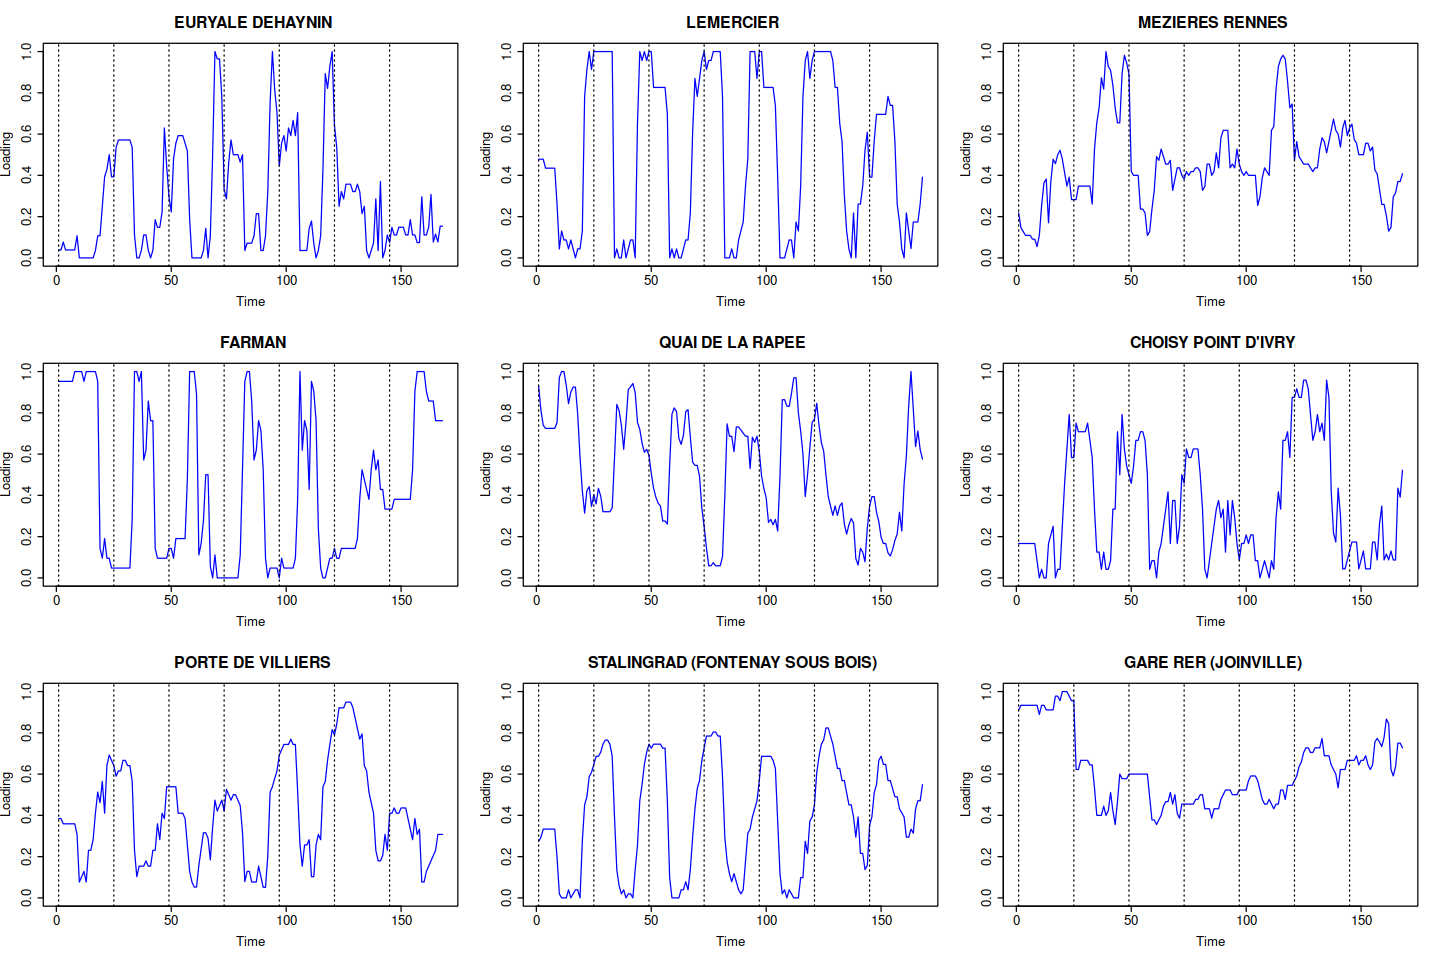

In [304]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
options(repr.plot.width=12, repr.plot.height=8, repr.plot.pointsize=8, repr.plot.res=120)
par(mfrow = c(3, 3))
for (i in 1:9){
  plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = rownames(x)[i])
  abline(v = timeTick, lty = "dotted")
}

In [305]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
rownames(x) <- 1:nrow(x)

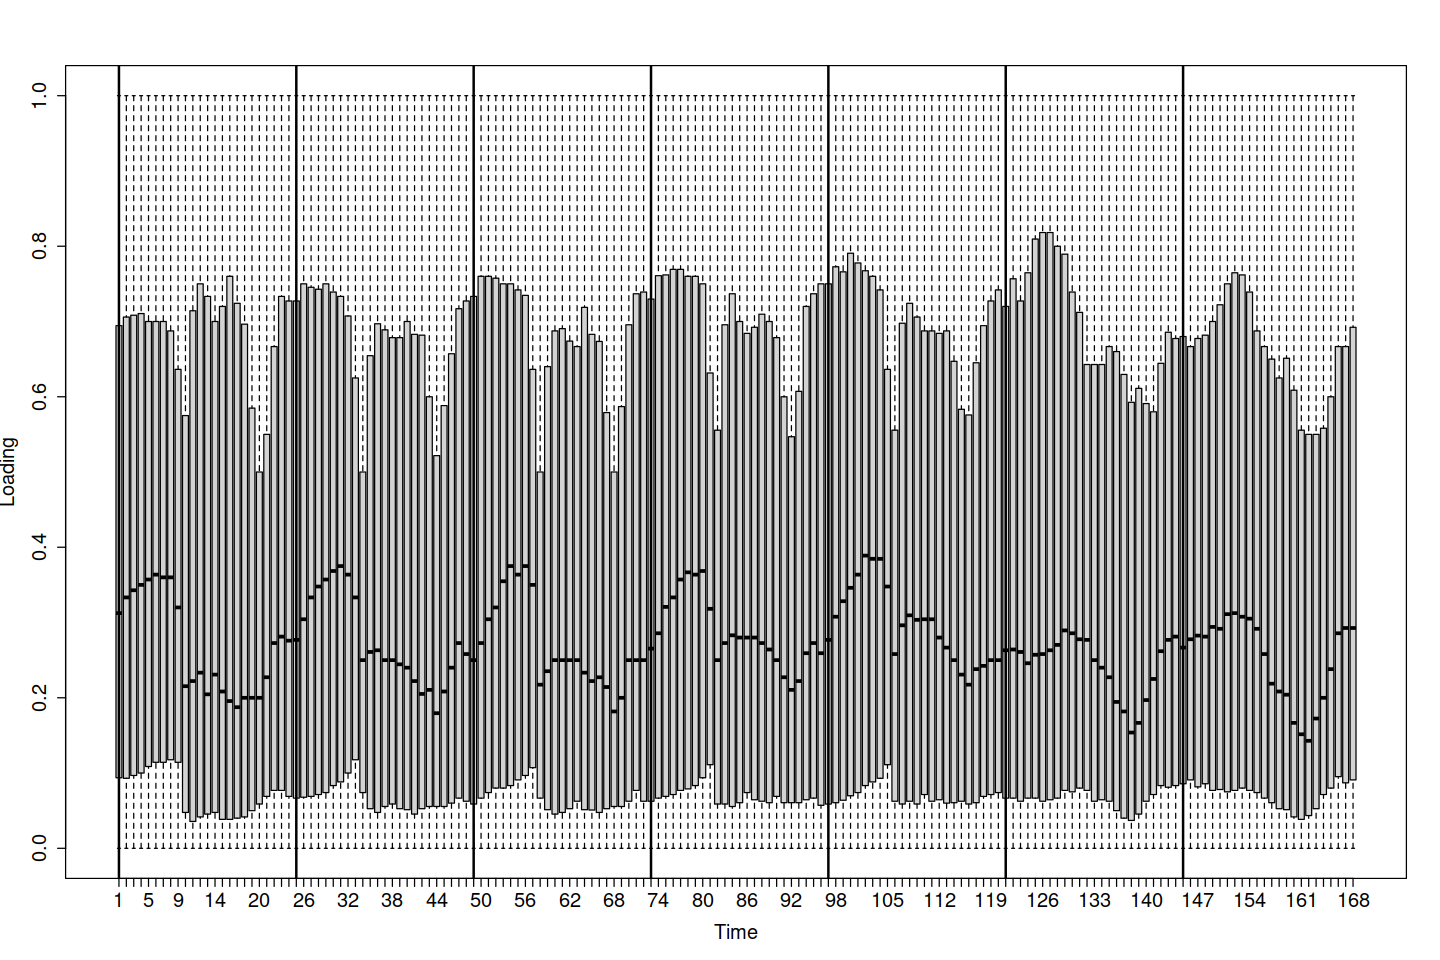

In [306]:
# Boxplot of the variables, sorted in time order
par(mfrow = c(1, 1))
boxplot(x, xlab = "Time", ylab = "Loading")
abline(v = timeTick, lwd = 2)

### Question 1.
Look at the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?

*Les journées de lundi à vendredi sont assez similaires, un pic la nuit et un pic entre midi et deux, ainsi que des périodes de plus faible chargement dans la matinée et en fin d'après-midi (heures d'arrivée et de départ du travail).*

*Le week-end est assez différent de la semaine, avec un retour des vélos dans les stations plus tardif la nuit (pas de travail le lendemain souvent). On ne voit d'ailleurs plus les pics correspondant à l'arrivée et au départ du lieu de travail.*

### Question 2.

a) Perform hierarchical clustering with Ward criterion. 
Plot the dendrogram and the heights versus the number of classes. 
Why choosing 6 classes seems logical?
Do you see another reasonable choice? 

b) What can you say of the sizes of the corresponding classes? 
Are there classes with only one individual? 
This could happen with another criterion: which one? Try it.

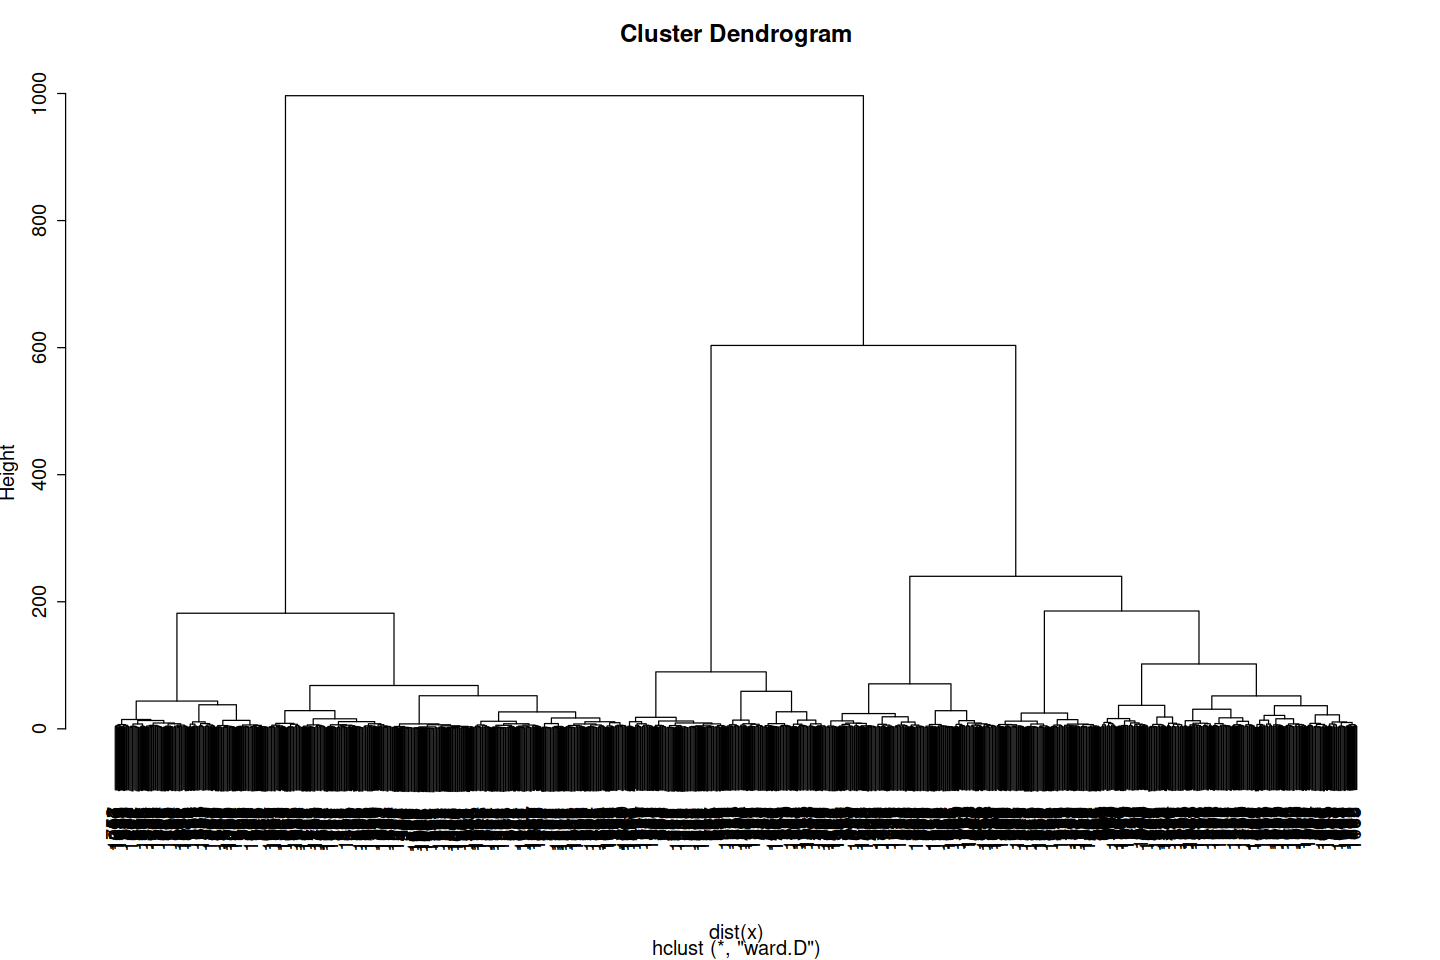

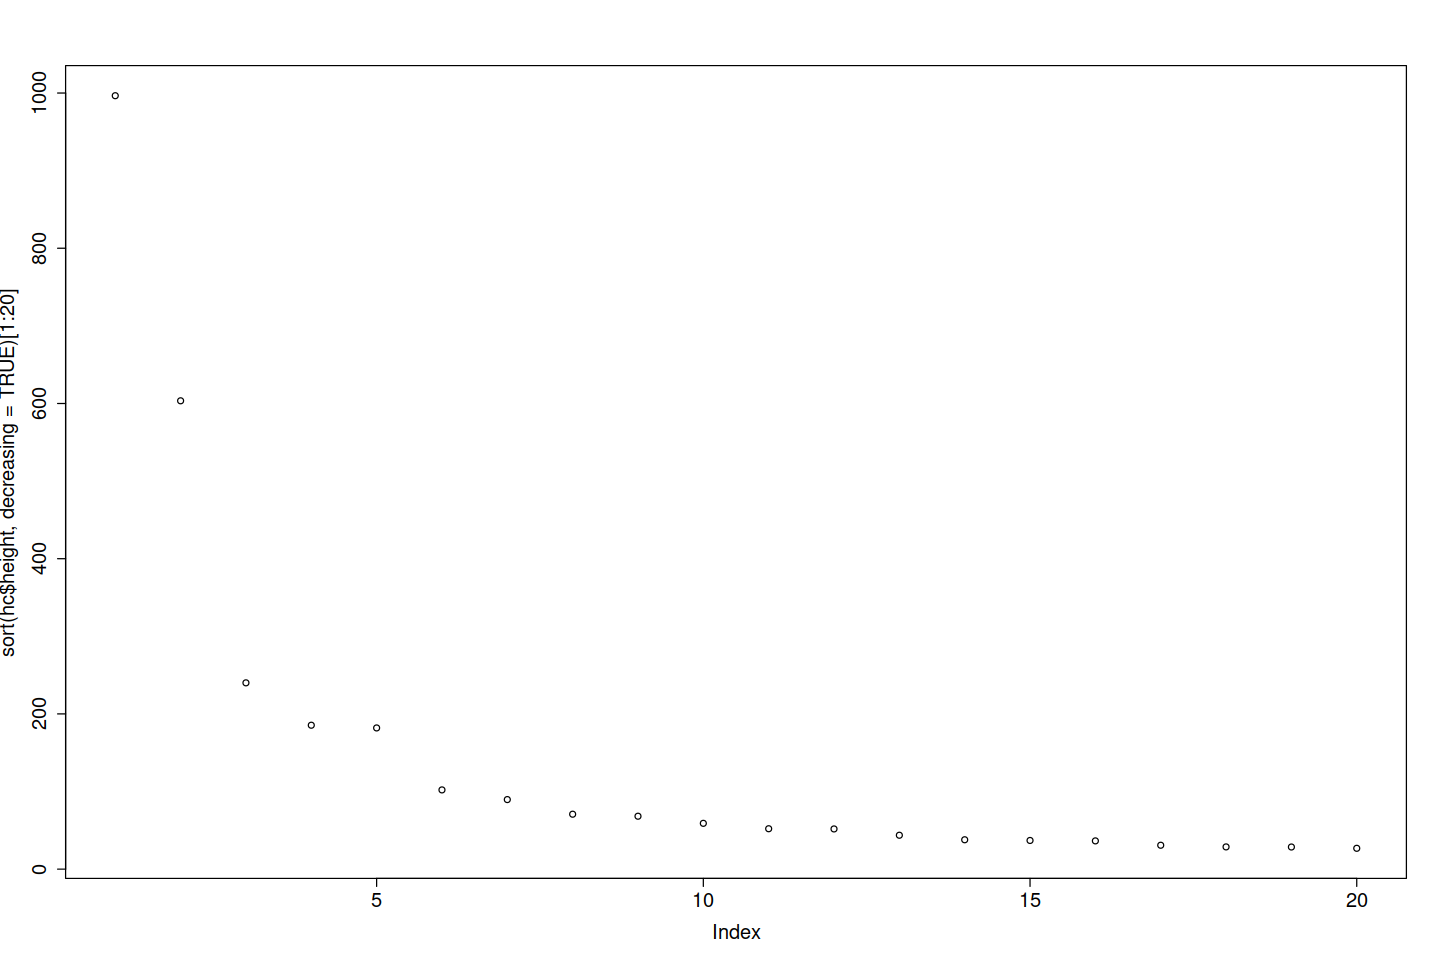

In [307]:
hc = hclust(dist(x), method = "ward.D")
plot(hc)
plot(sort(hc$height, decreasing = TRUE)[1:20])

*a. On choisit 6 classes car sur le graphique des hauteurs en fonction du nombre de classe on voit qu'à partir de 6 classes différentes, les sauts dans l'inertie sont beauoup plus faibles que ceux entre 1 et 6 classes.*

*Nous aurions aussi pu choisir 4 classes différentes, ce qui aurait fonctionné aussi, mais nos classes auraient été plus hétérogènes.*

In [308]:
class = cutree(hc, k = 6)
table(class)
table(cutree(hclust(dist(x), method = "single"), k=6))

class
  1   2   3   4   5   6 
163 245 191 147 343 100 


   1    2    3    4    5    6 
1183    1    1    2    1    1 

*Nous n'avons pas de classes quasiement vides, ce qui est une bonne chose.*

*Avec la méthode "single" nous obtenons plusieurs classes d'une taille de 1.*

### Question 3.
Perform k-means with K = 6 classes.

(a) Represent the center of each class as a discrete curve. 
Give the interpretation of the center of class 1 
(remember that vertical straight lines are separations between days, 
from Monday to Sunday). Same question with class 5.

(b) Which criterion aims at minimizing k-means? Is the optimum found local or global?

(c) In order to visualize the quality of the clustering, 
represent the boxplots of loading profiles for each time step, and for each class. 
Are the classes homogeneous? Interpret the results in terms 
of within-class variance and global variance.


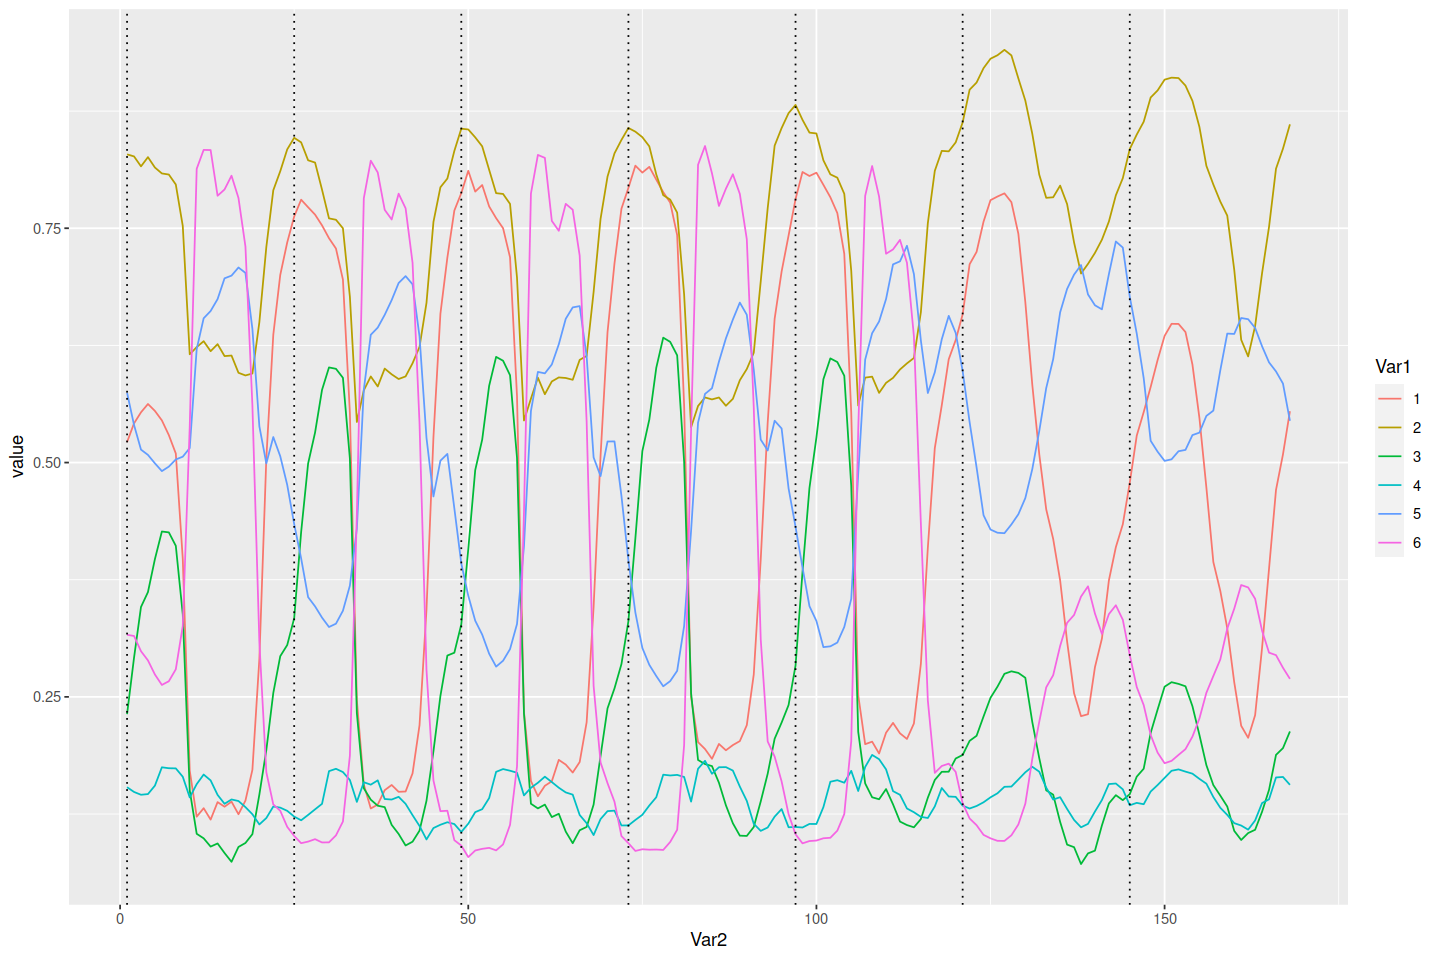

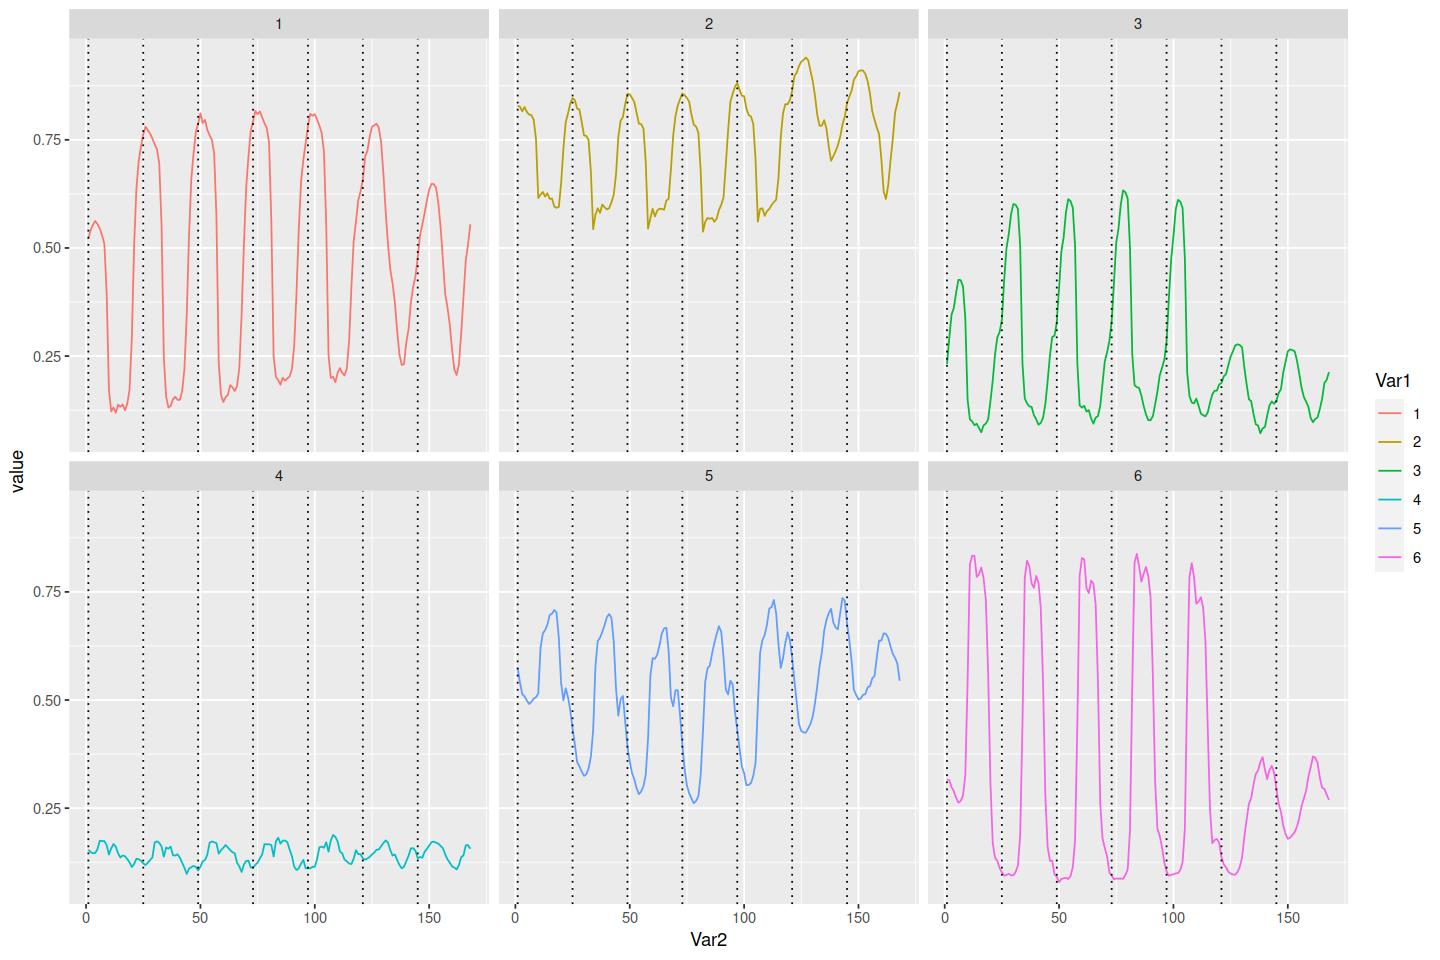

In [309]:
km = kmeans(x, centers = 6)
n_class = length(km$size)
color = rainbow(n_class)
# plot(km$center[1,], type = "l", col = color[1], ylim = c(0,1))
# abline(v = timeTick, lty = "dotted")
# for (i in 2:n_class) {
#     lines(km$center[i,], col = color[i])
# }
# legend("topleft", legend = paste("Class",seq(1,n_class)), col = color, lty = 1, ncol = 3)

# par(mfrow=c(2,3))
# for (i in 1:n_class) {
#     plot(km$center[i,], type = "l", col = color[i], main = paste("Class",i), ylim = c(0,1))
#     abline(v = timeTick, lty = "dotted")
# }
centers_long = melt(km$center)
centers_long$Var1 = as.factor(centers_long$Var1)
ggplot(data = centers_long, mapping = aes(x = Var2, y = value, col = Var1)) + geom_line() + geom_vline(xintercept = timeTick, linetype="dotted")
ggplot(data = centers_long, mapping = aes(x = Var2, y = value, col = Var1)) + geom_line() + facet_wrap(~Var1) + geom_vline(xintercept = timeTick, linetype="dotted")

***a.*** *Le centre de chaque classe représente la courbe d'occupation minimisant l'inertie dans la classe, i.e. la courbe la plus proche au sens des moindres carrés de toutes les autres courbes de la classe.*

*La classe 1 (en rouge) représente une classe de station très utilisées en milieu de journée la semaine, et très peu la nuit et le weekend.*

*La classe 5 (en bleu foncé) représente des stations très utilisées la nuit, et assez peu en journée.*

***b.*** *L'algorithme des k-means cherche à minimiser l'inertie intra-classe. Le minimum trouvé est local.*

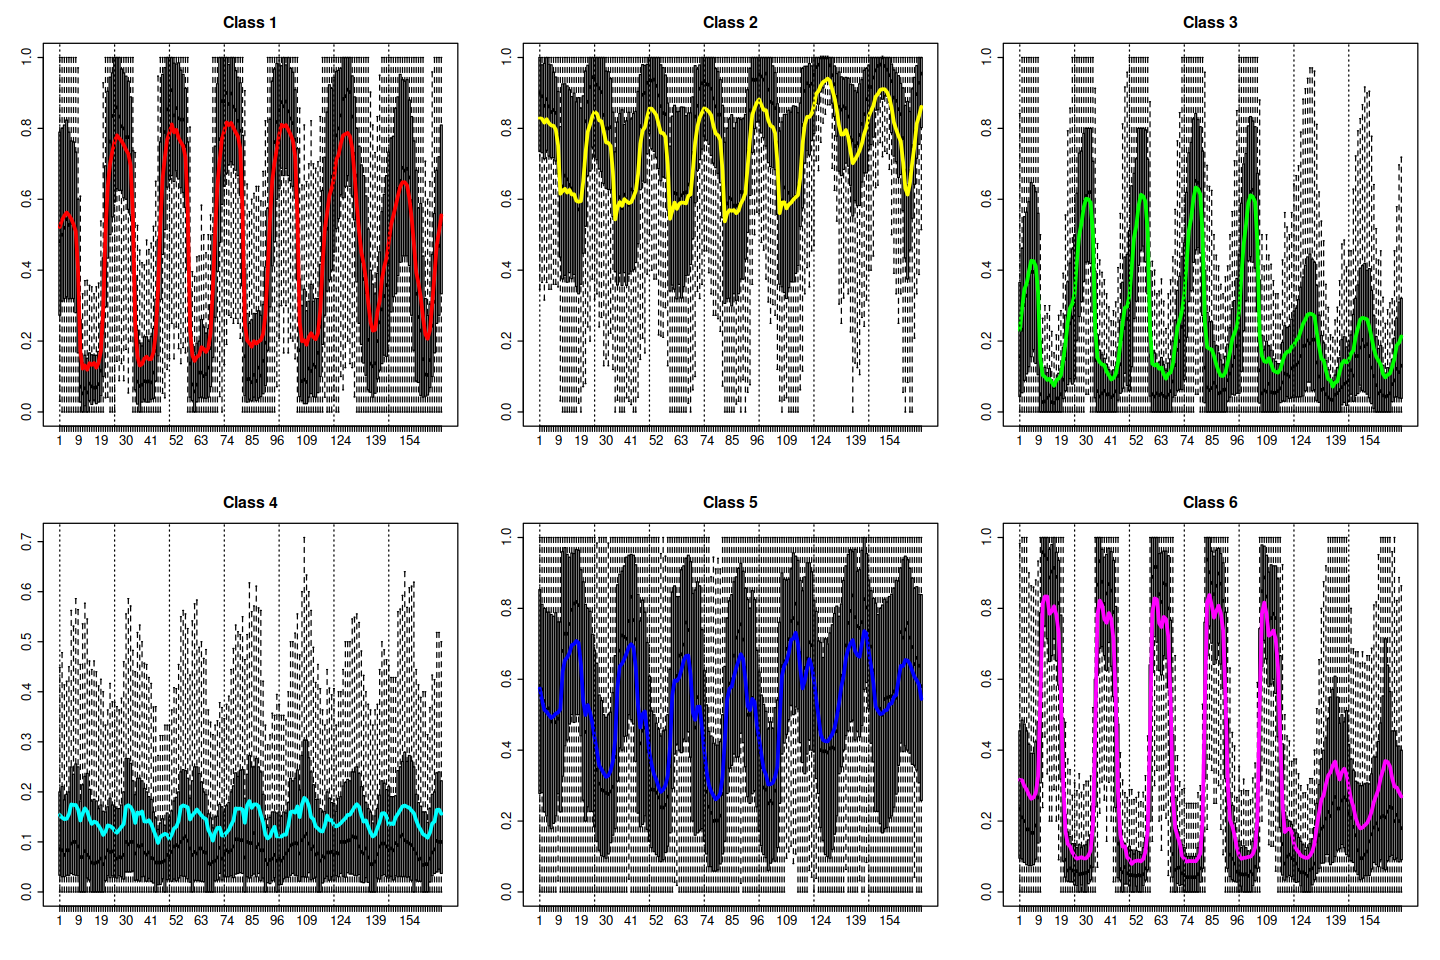

In [310]:
par(mfrow=c(2,3))
for (i in 1:n_class) {
    boxplot(x[which(km$cluster == i),], main = paste("Class",i), outline = FALSE)
    lines(km$center[i,], col = color[i], lwd = 3)
    abline(v = timeTick, lty = "dotted")
}
# x$class = km$cluster
# cluster_long = melt(x)
# cluster_long
#cluster_long$Var1 = as.factor(cluster_long$Var1)
#ggplot(data = cluster_long, mapping = aes(x = Var2, y = value, col = Var1)) + geom_boxplot() + facet_wrap(~Var1)# + geom_vline(xintercept = timeTick, linetype="dotted")

***c.*** *Les classes sont plutôt hommogènes. On observe une classe dont les stations sont souvent vides, et une donc les stations sont souvent chargées. Les autres classes ont une périodicité plus marquée.*

*Variance intra-classe faible, et variance inter-classe plus élevée.*

### Question 4. 

Plot the results on a map, using the station coordinates.
In practice, what is missing to interpret the results?

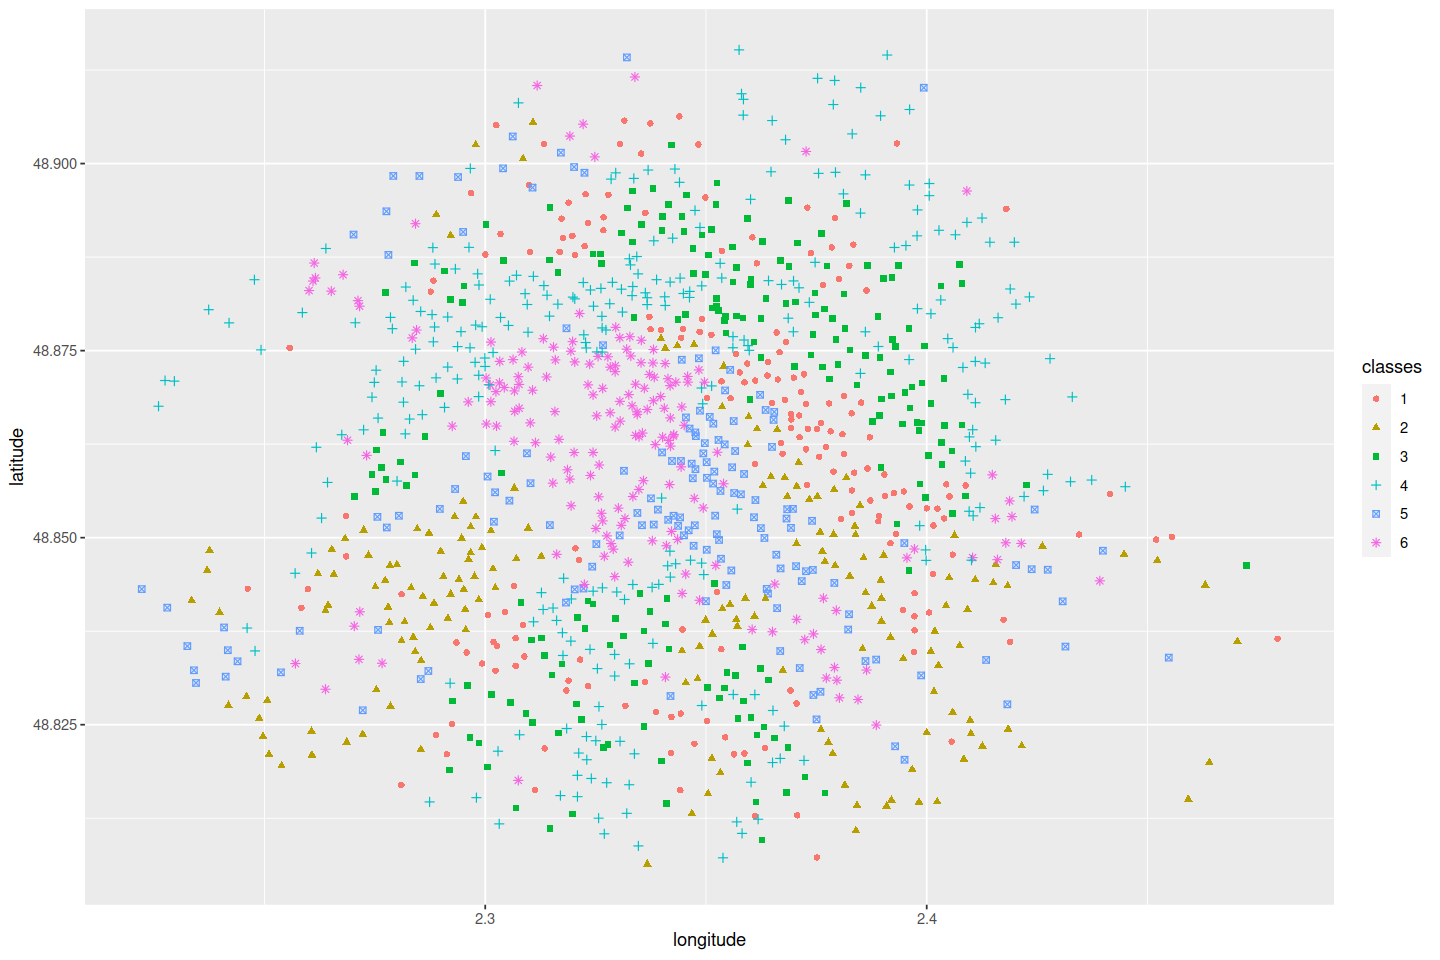

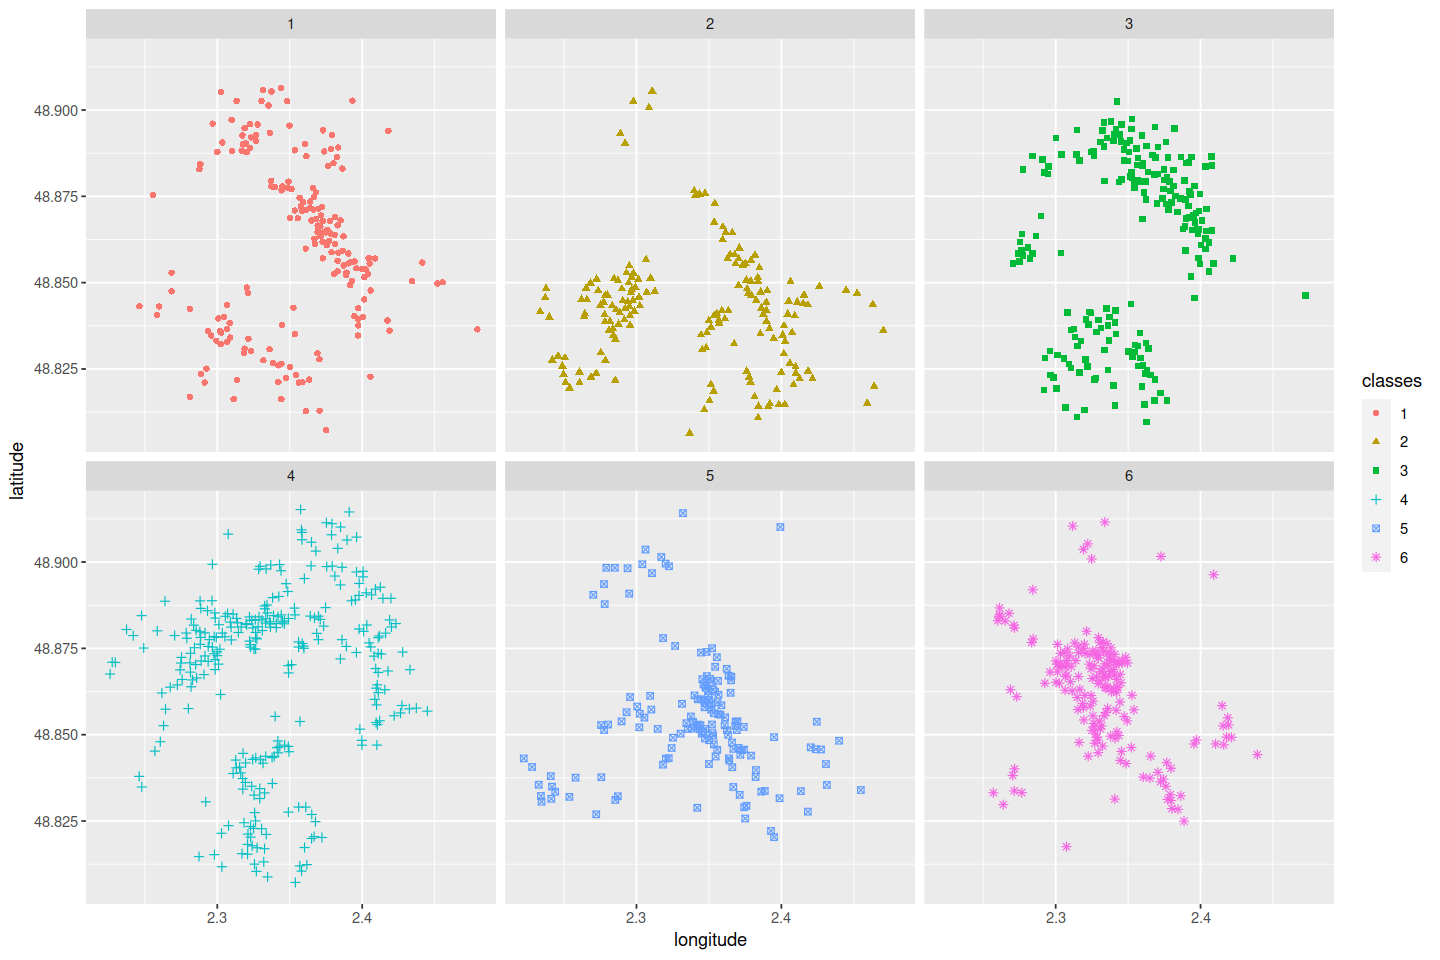

In [311]:
coord$classes = as.factor(km$cluster)
#plot(coord, col = km$cluster, pch = km$cluster)
#legend("topleft", legend = paste("Class",seq(1,n_class)), col = km$cluster, pch = km$cluster, ncol = 3)
ggplot(data = coord, mapping = aes(x = longitude, y = latitude, col = classes, shape = classes)) + geom_point()
ggplot(data = coord, mapping = aes(x = longitude, y = latitude, col = classes, shape = classes)) + geom_point() + facet_wrap(~classes)

In [312]:
paris = ggmap(get_stamenmap(rbind(as.numeric(paste(geocode_OSM("Paris")$bbox))), zoom = 14), darken = c(0.6, "white"))

84 tiles needed, this may take a while (try a smaller zoom).



Pour interpréter correctement les données, il nous faudrait ajouter une carte de Paris en dessous des points.

Warning message:
“Removed 68 rows containing missing values (geom_point).”
Warning message:
“Removed 68 rows containing missing values (geom_point).”


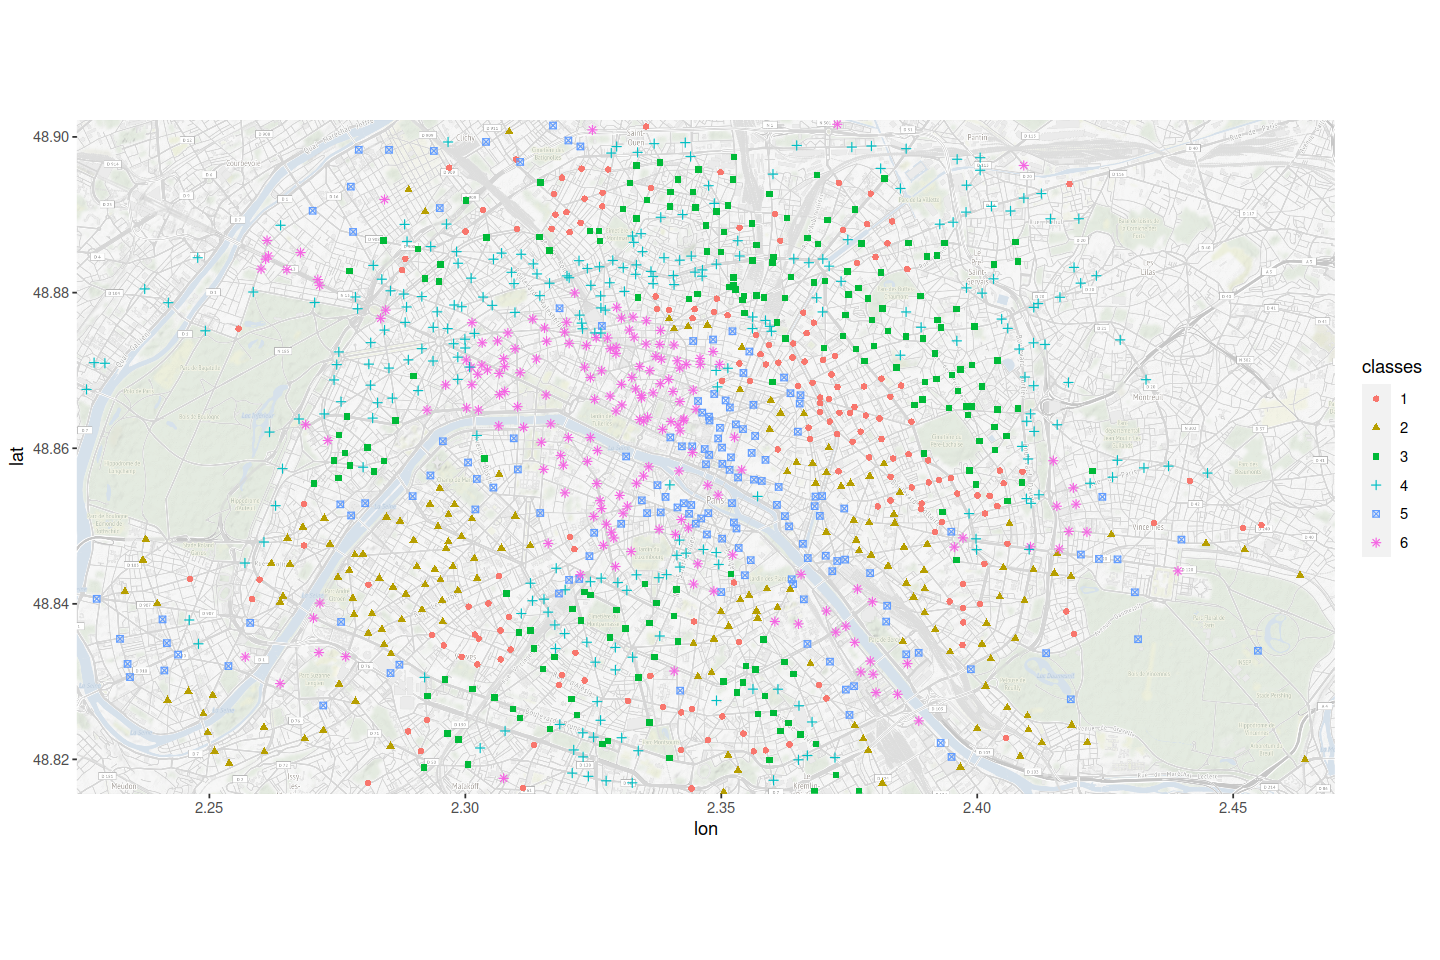

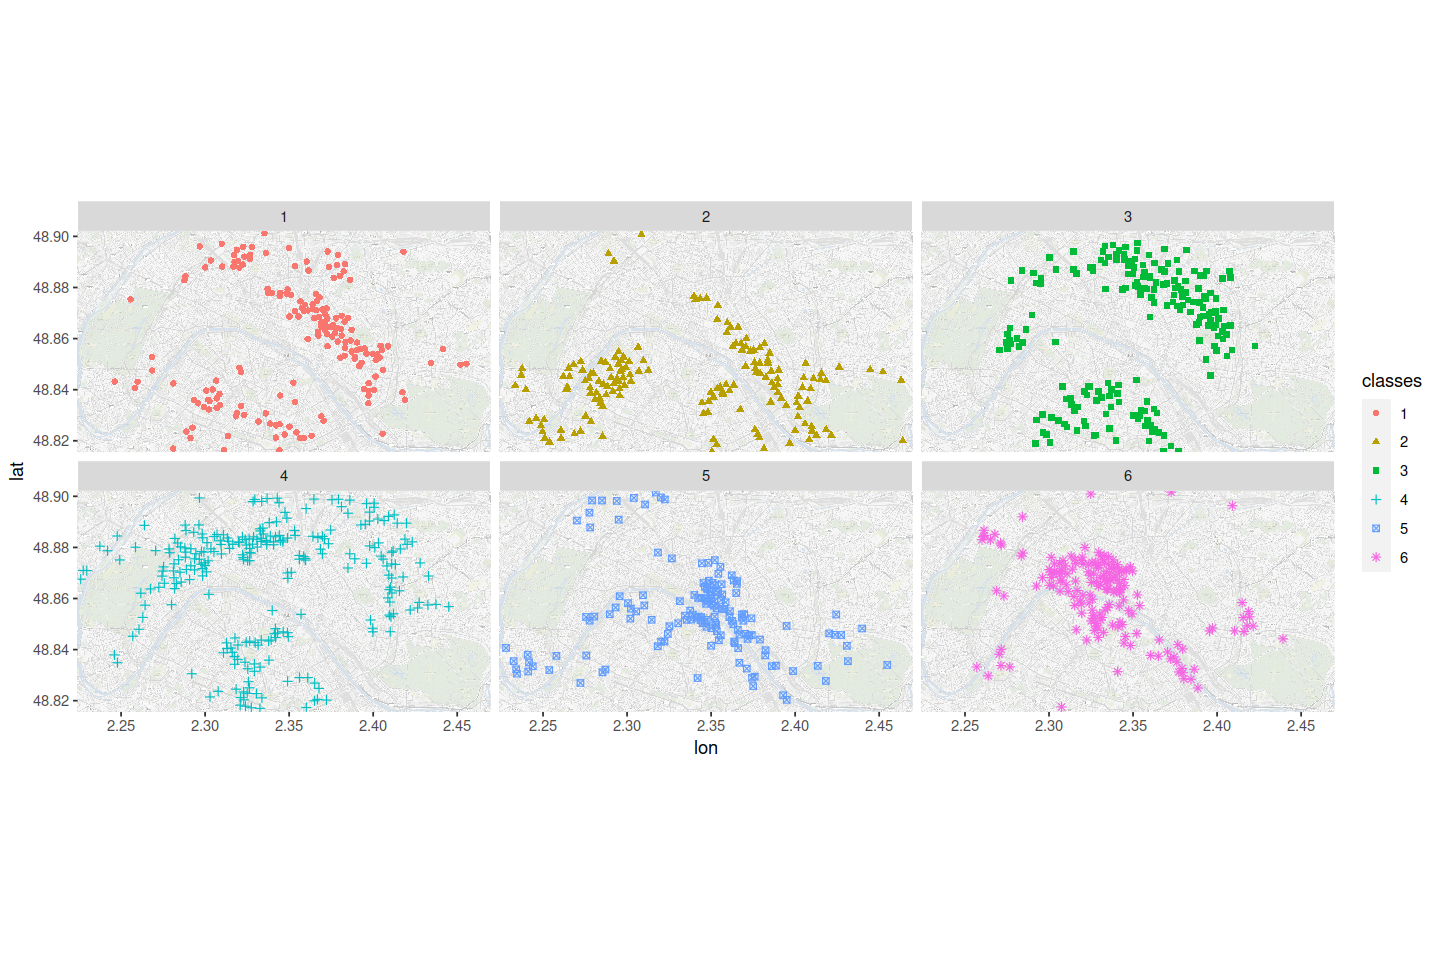

In [313]:
paris + geom_point(data = coord, aes(x = longitude, y = latitude, col = classes, shape = classes))
paris + geom_point(data = coord, aes(x = longitude, y = latitude, col = classes, shape = classes)) + facet_wrap(~classes)

### Question 5
Ready to go further? Now we consider all the data (not a subsample).
We need to reduce dimension, by approximating the functions in a Fourier basis (for instance). Then redo questions 1-4 by doing clustering on the coefficients of the Fourier basis. 

Help: First run the example of function funFEM.

In [314]:
help("funFEM")
help("smooth.basis")
help("basisfd")

*On va supposer le chargement avec une période de 7 jours. Pour avoir une précision journalière, on veut avoir au moins 7 oscillations dans notre semaine. On a donc 7 sinus, 7 cosinus et une constante, ce qui nous donne 15 fonctions dans notre base. Pour plus de précision, on peut prendre $\small 4 \times 7+1=29$ fonctions.*

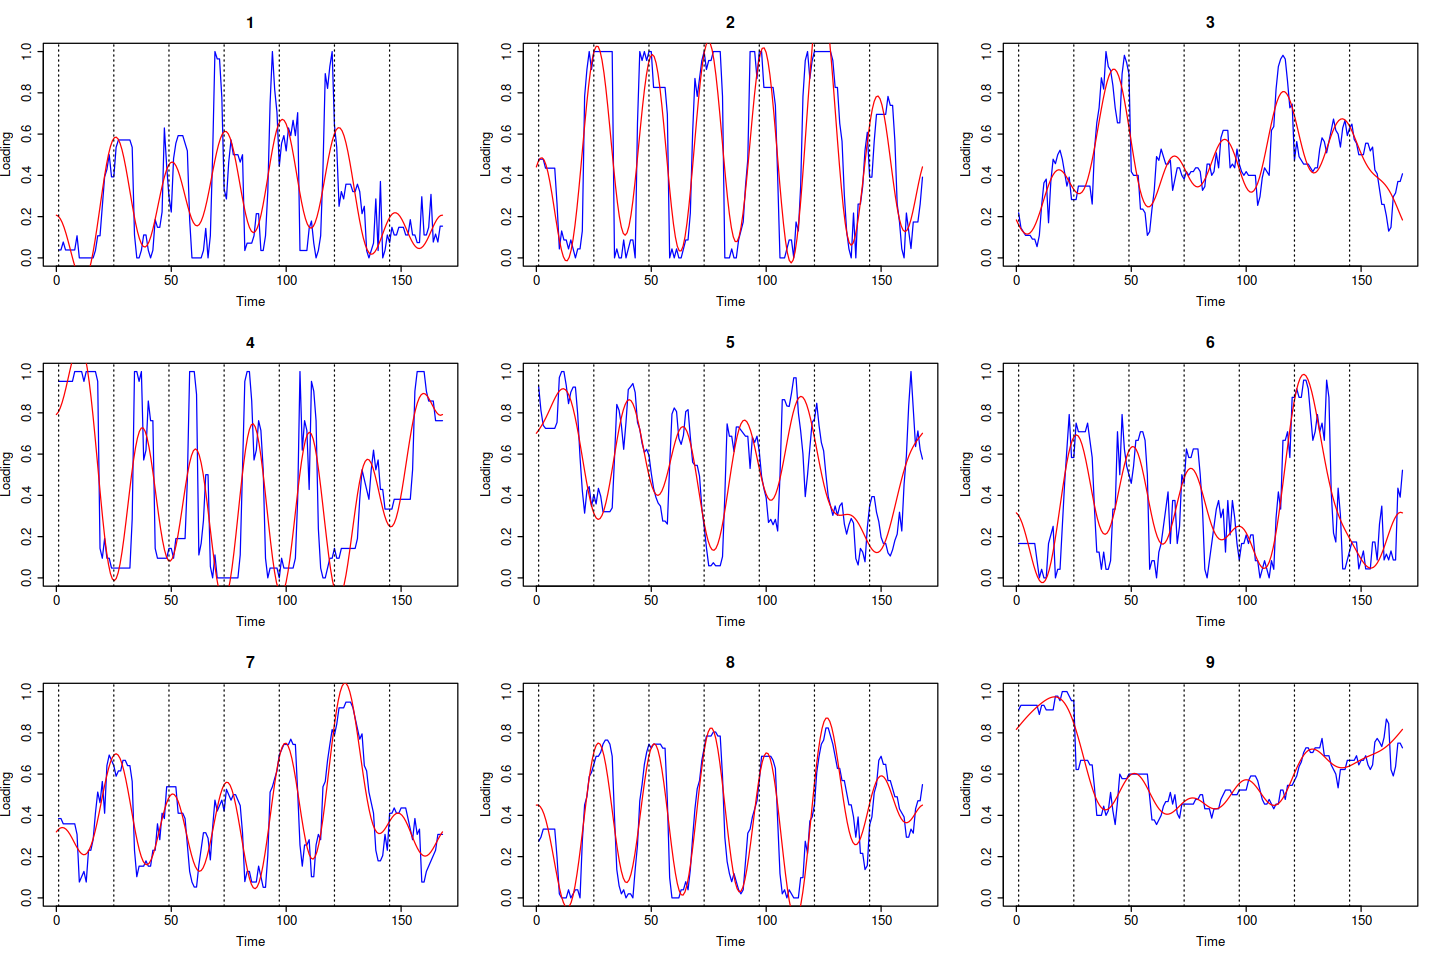

In [315]:
basis = create.fourier.basis(c(0,168), nbasis = 15)
fdobj <- smooth.basis(1:168,t(x),basis)$fd
par(mfrow = c(3, 3))
for (i in 1:9){
  plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1),
       xlab = "Time", ylab = "Loading", main = rownames(x)[i])
    lines(fdobj[i,], col = "red")
  abline(v = timeTick, lty = "dotted")
}

*À la place de faire notre clustering en dimensions 168, on va pouvoir le faire en dimension 15.*

[1] "done"

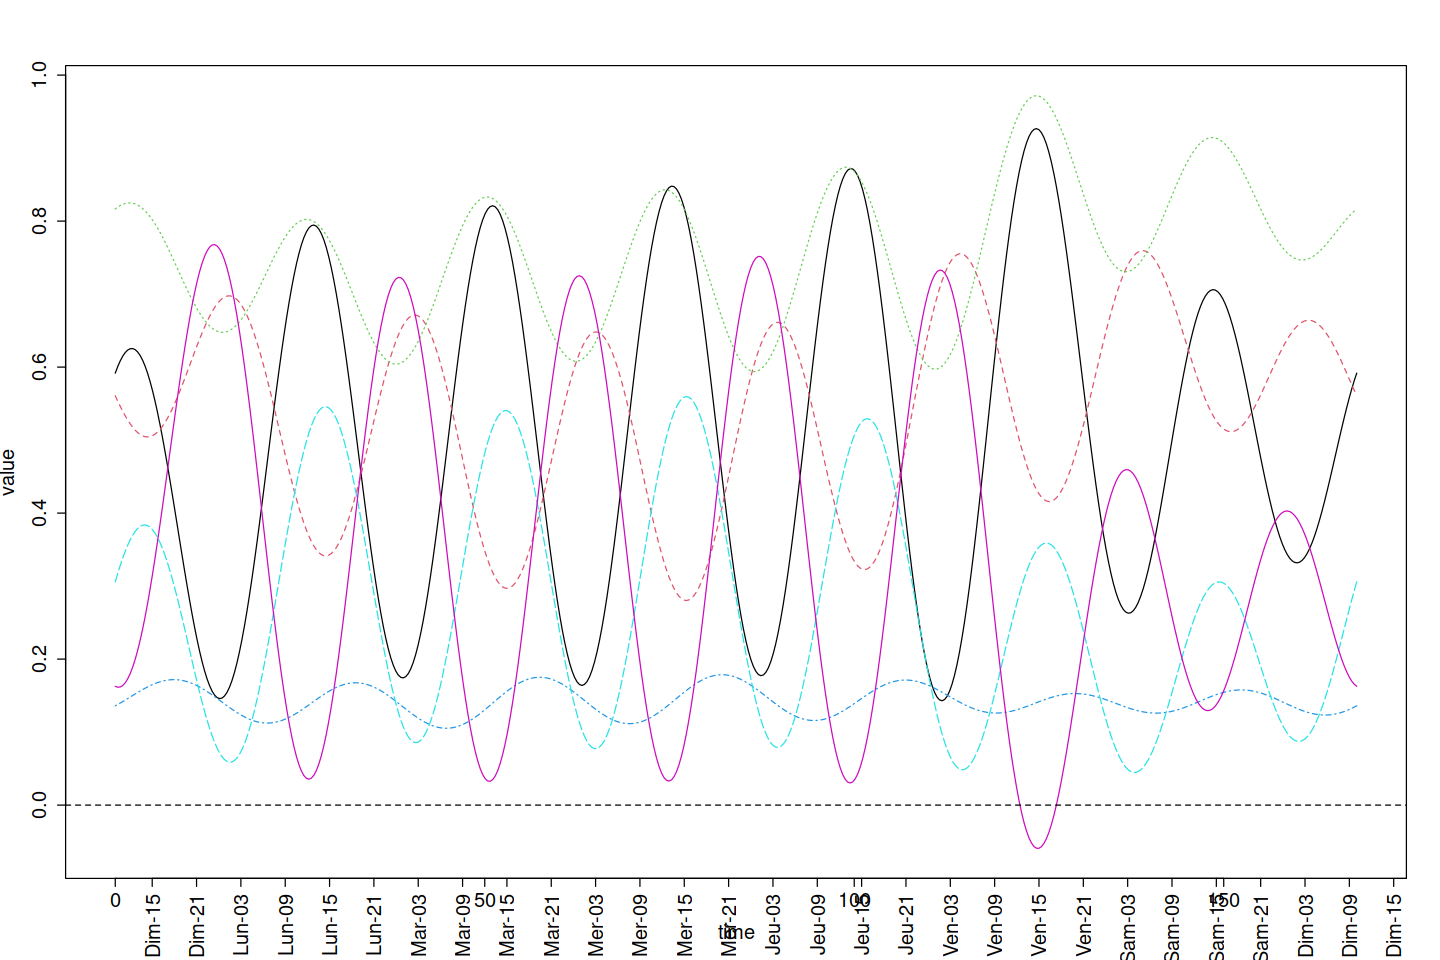

In [316]:
# Clustrering with kmeans
res = kmeans(t(fdobj$coefs), centers = 6, )

# Visualization of group means
fdmeans = fdobj; fdmeans$coefs = t(res$centers)
plot(fdmeans,col=1:res$K,xaxt='n',lwd=2)
axis(1,at=seq(5,181,6),labels=velib$dates[seq(5,181,6)],las=2)